# Supervised Classifier with Synthetic Training Data

Following up on the "Supervised simple classifier test" notebook, this notebook tests a "simple classifier" model that is supervised on prelabeled synthetic Rainfall data for OCaml.  

Prelabeled synthetic Rainfall data is generated with probabilistic grammars that output the distribution of solutions to the Rainfall problem in OCaml. See the grammar in [ocaml.py](https://github.com/willcrichton/autoplan/blob/master/grammars/rainfall/ocaml.py) for the source code. This generative model was first explored in [1], where they explored the use of prograbilistic grammars to generate programs that could then be used to train neural networks on several prelabeled students solutions, and were then used to give students feedback. 

In this notebook, we take advantage of this generative model in order to explore how our model behaves with respect to data. Specifically, we hope to understand if the model has similar accuracy when trained on synthetic data and, if so, we want to understand how the model's accuracy change when given more synthetic training data.  

First we set up the packages we'll use, as well as the local repositories of student data:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
from autoplan.trainer import ClassifierTrainer
from autoplan.dataset import PrelabeledDataset, build_synthetic_dataset, build_prelabeled_dataset
from autoplan.generator import ProgramGenerator
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.token import PyretTokenizer, OCamlTokenizer
from scripts.rainfall_ingest import ingest_dataset

from grammars.rainfall.ocaml import Program
from grammars.rainfall.labels import GeneralRainfallLabels

from tqdm import tqdm_notebook as tqdm
import pandas as pd
import torch
import os
import numpy as np
import torch.nn as nn
from pprint import pprint

# device = torch.device('cpu')
device = torch.device('cuda:0')
REPO_DIR = os.path.expanduser('~/autoplan')

# Student Dataset

In this section, we specify and ingest the dataset of students' OCaml solutions. Student solutions are preprocessed (as explained on the "Supervised simple classifier ablation and parameter sweep" notebook) and tokenized such that all identifies (strings) are normalized. 

We will use students solutions to evaluate the model accuracy in labeling student-generated data, despite being trained on synthetic data. 

In [4]:
# T1 refers to the OCaml data
dataset_name = 'T1'
student_dataset = ingest_dataset(dataset_name)

In [5]:
# Run this cell optionally to see a sample of a student program
print(student_dataset.dataset[0]['source'])

let rec rainfall (alof : float list) =
  (let rec sum_helper (alof : float list) (sum : float) (counter : float) =
     (match (alof, counter) with
      | ([],0.) -> failwith "Empty list."
      | ((-999.)::_,0.) -> failwith "Empty list."
      | ([],_) -> (sum, counter)
      | ((-999.)::_,_) -> (sum, counter)
      | (hd::tl,_) ->
          if hd >= 0.
          then sum_helper tl (sum +. hd) (counter +. 1.)
          else sum_helper tl sum counter : (float* float)) in
   match sum_helper alof 0. 0. with | (s,c) -> s /. c : float)



# Synthetic Dataset

In this section, we specify and generate the dataset of synthetic OCaml solutions. We specify the number of samples we wish to generate, the grammar we would like to generate samples from, the labels that are used to classify these samples, as well as adaptive and unique sampling -- two hyperparameters that can be set by the user to influence dataset diversity.

Adaptive sampling is a sampling technique first described in [2], where dominant choices are dynamically penalized, such that rare programs are more likely to be generated within the same production batch. Unique sampling simply forces the generator to generate unique samples. 

We will use synthetic solutions generated by this grammar to train and validate the model. 

In [6]:
N_samples = 1000
synthetic_dataset = build_synthetic_dataset(
    GeneralRainfallLabels,
    N=N_samples,
    tokenizer=OCamlTokenizer(),
    generator=ProgramGenerator(grammar=Program(), adaptive=True),
    vocab_index=student_dataset.vocab_index,
    unique=False)

Generating programs...
Generated 600 unique programs.
Tokenizing programs...
Building dataset metadata...


In [7]:
# Run this cell optionally to see a sample program generated from our grammar
print(synthetic_dataset.dataset[1]['source'])

let rainfall list_name =
  let helper_name list_name addition_var counter_var =
    match list_name with
    | [] -> if counter_var = 0 then 0 else addition_var / counter_var
    | head::tail -> helper_name [] addition_var counter_var
    | head::tail ->
        if head >= 0
        then helper_name tail (head + addition_var) (counter_var + 1)
        else helper_name tail addition_var counter_var in
  helper_name list_name 0 0



# Model 

In this section, we specify which classification model we are going to use as well as the hyperparameters configuration. Based on our previous ablation study, we choose GRU or LSTM, and a size of 512 for both the hidden layer and the embedding. 

In [8]:
model_options = {
    'model' : nn.GRU,
    'hidden_size' : 512,
    'embedding_size' : 512
}

trainer = ClassifierTrainer(synthetic_dataset, device, model_opts=model_options)

In [9]:
losses = []
train_eval = []
val_eval = []
student_eval = []

for _ in tqdm(range(50)):
    losses.append(trainer.train_one_epoch())
    train, val = trainer.eval()
    train_eval.append(train)
    val_eval.append(val)
    
    trainer.model.eval()
    student_eval.append(trainer.eval_on(student_dataset.loader(student_dataset.dataset)))
    trainer.model.train() 

# Evaluation

In this section we analyze the performance of our model. First we look at how loss varied between epochs. Loss refers to the distance between the predicted label and the true label. As you can see in the graph below, very quickly the loss reaches and stabilizes at zero, suggesting that the network has learned everything that it could have learned. 

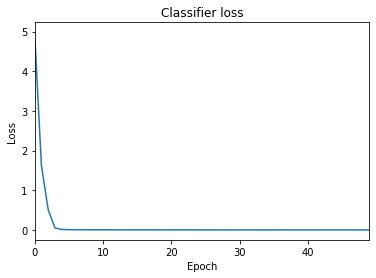

In [10]:
# Loss over epoch
plot_loss(losses, title='Classifier loss')

Then, we look at the model accuracy at each epoch, as evaluated on the training set and on the evaluation set. As you can see in the next two graphs below, the network very quickly memorized the training set.

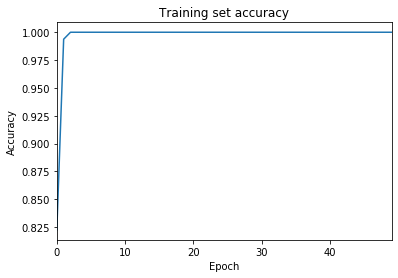

In [11]:
# Accuracy over epoch as measured on the training set
plot_accuracy(train_eval, title='Training set accuracy')

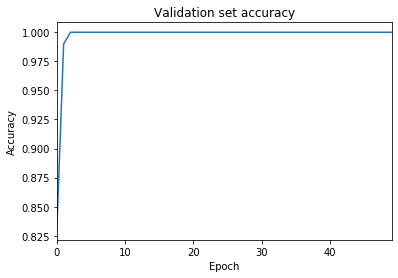

In [12]:
# Accuracy over epoch as measured on the validation set
plot_accuracy(val_eval, title='Validation set accuracy')

Looking at the accuracy measured on the student dataset, however, we see that the model accuracy starts off at the baseline accuracy reached by the "Supervised simple classifier test", and then quickly overfits at 78% accuracy. Between epochs 20 - 40, the model reaches 80% accuracy, similar to the accuracy reached by the simple classifier post-ablation.

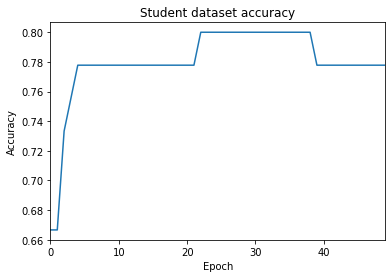

In [13]:
# Accuracy over epoch as measured on the validation set
plot_accuracy(student_eval, title='Student dataset accuracy')

Finally, we look at the performance of the fully trained model on student data as shown by the confusion matrix. Specifically, we look at which fraction of the true labels our model correctly predicted. 

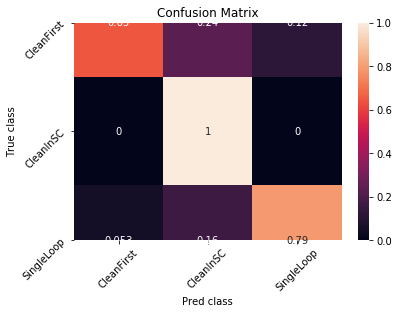

In [14]:
# Accuracy at the end of the training loop, measured on the student dataset
trainer.model.eval()
trainer.eval_on(student_dataset.loader(student_dataset.dataset)).plot_cm("Confusion Matrix", normalize=True)

# Conclusion

As shown in the confusion matrix, our model reached perfect accuracy at learning to classify the "Clear Multiple" label, similar accuracy to the post-ablation classifier at classifying the "Single Loop" label, and promising accuracy at classifying the "Clean First" label. 

These numbers are promising for two reasons. First, they suggest that we may be able to reach perfect accuracy on all labels provided that we tune our hyperparameters and our dataset design correctly. Second, the fact that the accuracy as measured on the student dataset never reaches 100% suggest that these two datasets -- while similar -- are not identical, thus we are not simply memorizing the validation set.  

Our next step is to run an ablation test and parameter swap on this model in order to understand how each hyperparameter and dataset design choice (adaptive, unique) impacts the final performance, as well as how the size of the dataset affects classification accuracy. Additionally, we will evaluate the minimum edit distance between the synthetic data generated by our grammars and the original student solutions in order to evaluate which portion of our validation set may be present in our training set, and to what extent.

# References

1. M. Wu, M. Mosse, N. Goodman, and C. Piech. Zero shot learning for code education: Rubric sampling with deep learning inference. arXiv preprint arXiv:1809.01357, 2018.
2. A. Malik, M. Wu, V. Vasavada, J, Song, J. Mitchell, N. Goodman, C. Piech. Generative Grading: Neural Approximate Parsing for Automated Student Feedback. arXiv:1905.09916, 2019. 